In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
num_epochs = 70
batch_size = 64

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# 데이터 전처리 및 변환
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 데이터 증강 (좌우 반전)
    transforms.RandomCrop(32, padding=4),  # 데이터 증강 (랜덤 자르기)
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # CIFAR-10의 평균과 표준편차로 정규화
])

# 전체 훈련 데이터셋 로드
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 훈련 데이터셋을 80% 훈련용과 20% 검증용으로 분할
train_size = int(0.8 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size])

# 테스트 데이터셋 로드
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 데이터로더 정의
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
# 모델 정의 (3채널 입력, CIFAR-10에 맞게 수정)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 합성곱 층
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3채널 입력
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # 완전 연결 층
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # CIFAR-10은 32x32 이미지, MaxPool 후 16x16
        self.fc2 = nn.Linear(128, 10)  # CIFAR-10은 10개의 클래스
        # 활성화 함수와 드롭아웃
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))   # [batch_size, 32, 32, 32]
        x = self.relu(self.conv2(x))   # [batch_size, 64, 32, 32]
        x = self.pool(x)               # [batch_size, 64, 16, 16]
        x = self.dropout(x)
        x = x.view(-1, 64 * 16 * 16)   # 평탄화
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
# 모델, 손실 함수, 옵티마이저 설정
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# 학습 및 검증 과정에서 손실과 정확도를 저장할 리스트 초기화
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

In [17]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    startStr = f'Epoch {epoch+1:2d}/{num_epochs} \033[34m' + 'Train ' + '\033[0m'
    with tqdm(total=len(train_loader), desc=startStr) as pbar:
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
            pbar.update(1)
        train_loss = train_loss / train_total
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        str = f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.3f}%'
        pbar.set_postfix_str(str)

In [18]:
def valid_or_test(mode, model, device, dataloader):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        if mode == 'valid':
            startStr = f'Epoch {epoch+1:2d}/{num_epochs} \033[34m' + 'Valid ' + '\033[0m'
        elif mode == 'test':
            startStr = f'Epoch {epoch+1:2d}/{num_epochs} \033[34m' + 'Test ' + '\033[0m'

        with tqdm(total=len(dataloader), desc=startStr) as pbar:
            for data, target in dataloader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)

                loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                pbar.update(1)

            loss = loss / total
            accuracy = 100 * correct / total
            if mode == 'valid':
                endStr = f'Valid Loss: {loss:.4f}, Valid Acc: {accuracy:.3f}%'
            elif mode == 'test':
                endStr = f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.3f}%'
            pbar.set_postfix_str(endStr)

    if mode == 'valid':
        valid_losses.append(loss)
        valid_accuracies.append(accuracy)
        print('-'*110)

In [19]:
for epoch in range(num_epochs):
    train(model, device, train_loader, optimizer, epoch)
    valid_or_test('valid', model, device, valid_loader)

valid_or_test('test', model, device, test_loader)

Epoch  1/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 31.06it/s, Valid Loss: 0.0022, Valid Acc: 50.210%]


--------------------------------------------------------------------------------------------------------------


Epoch  2/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.92it/s, Valid Loss: 0.0015, Valid Acc: 57.200%]


--------------------------------------------------------------------------------------------------------------


Epoch  3/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 36.40it/s, Valid Loss: 0.0013, Valid Acc: 59.340%]


--------------------------------------------------------------------------------------------------------------


Epoch  4/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.87it/s, Valid Loss: 0.0019, Valid Acc: 62.470%]


--------------------------------------------------------------------------------------------------------------


Epoch  5/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 30.29it/s, Valid Loss: 0.0013, Valid Acc: 63.910%]


--------------------------------------------------------------------------------------------------------------


Epoch  6/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 31.83it/s, Valid Loss: 0.0011, Valid Acc: 65.500%]


--------------------------------------------------------------------------------------------------------------


Epoch  7/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 36.61it/s, Valid Loss: 0.0010, Valid Acc: 66.050%]


--------------------------------------------------------------------------------------------------------------


Epoch  8/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.78it/s, Valid Loss: 0.0015, Valid Acc: 65.320%]


--------------------------------------------------------------------------------------------------------------


Epoch  9/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.14it/s, Valid Loss: 0.0011, Valid Acc: 67.720%]


--------------------------------------------------------------------------------------------------------------


Epoch 10/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 30.99it/s, Valid Loss: 0.0012, Valid Acc: 67.230%]


--------------------------------------------------------------------------------------------------------------


Epoch 11/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 31.59it/s, Valid Loss: 0.0013, Valid Acc: 68.090%]


--------------------------------------------------------------------------------------------------------------


Epoch 12/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.56it/s, Valid Loss: 0.0013, Valid Acc: 68.210%]


--------------------------------------------------------------------------------------------------------------


Epoch 13/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.61it/s, Valid Loss: 0.0008, Valid Acc: 68.780%]


--------------------------------------------------------------------------------------------------------------


Epoch 14/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 31.76it/s, Valid Loss: 0.0009, Valid Acc: 69.210%]


--------------------------------------------------------------------------------------------------------------


Epoch 15/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 30.09it/s, Valid Loss: 0.0009, Valid Acc: 69.340%]


--------------------------------------------------------------------------------------------------------------


Epoch 16/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.85it/s, Valid Loss: 0.0012, Valid Acc: 70.710%]


--------------------------------------------------------------------------------------------------------------


Epoch 17/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 28.27it/s, Valid Loss: 0.0009, Valid Acc: 70.260%]


--------------------------------------------------------------------------------------------------------------


Epoch 18/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 32.88it/s, Valid Loss: 0.0012, Valid Acc: 69.770%]


--------------------------------------------------------------------------------------------------------------


Epoch 19/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 33.95it/s, Valid Loss: 0.0015, Valid Acc: 69.650%]


--------------------------------------------------------------------------------------------------------------


Epoch 20/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 30.09it/s, Valid Loss: 0.0013, Valid Acc: 71.210%]


--------------------------------------------------------------------------------------------------------------


Epoch 21/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.52it/s, Valid Loss: 0.0011, Valid Acc: 70.090%]


--------------------------------------------------------------------------------------------------------------


Epoch 22/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 36.28it/s, Valid Loss: 0.0013, Valid Acc: 70.840%]


--------------------------------------------------------------------------------------------------------------


Epoch 23/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.10it/s, Valid Loss: 0.0013, Valid Acc: 70.230%]


--------------------------------------------------------------------------------------------------------------


Epoch 24/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 30.48it/s, Valid Loss: 0.0013, Valid Acc: 71.370%]


--------------------------------------------------------------------------------------------------------------


Epoch 25/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 32.32it/s, Valid Loss: 0.0012, Valid Acc: 70.790%]


--------------------------------------------------------------------------------------------------------------


Epoch 26/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.32it/s, Valid Loss: 0.0013, Valid Acc: 71.930%]


--------------------------------------------------------------------------------------------------------------


Epoch 27/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.10it/s, Valid Loss: 0.0008, Valid Acc: 71.190%]


--------------------------------------------------------------------------------------------------------------


Epoch 28/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 33.91it/s, Valid Loss: 0.0010, Valid Acc: 71.030%]


--------------------------------------------------------------------------------------------------------------


Epoch 29/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 30.60it/s, Valid Loss: 0.0012, Valid Acc: 71.040%]


--------------------------------------------------------------------------------------------------------------


Epoch 30/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 34.51it/s, Valid Loss: 0.0009, Valid Acc: 70.960%]


--------------------------------------------------------------------------------------------------------------


Epoch 31/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 34.45it/s, Valid Loss: 0.0012, Valid Acc: 71.820%]


--------------------------------------------------------------------------------------------------------------


Epoch 32/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 27.15it/s, Valid Loss: 0.0015, Valid Acc: 72.030%]


--------------------------------------------------------------------------------------------------------------


Epoch 33/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 34.26it/s, Valid Loss: 0.0011, Valid Acc: 71.920%]


--------------------------------------------------------------------------------------------------------------


Epoch 34/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 34.04it/s, Valid Loss: 0.0008, Valid Acc: 72.410%]


--------------------------------------------------------------------------------------------------------------


Epoch 35/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 29.24it/s, Valid Loss: 0.0012, Valid Acc: 72.760%]


--------------------------------------------------------------------------------------------------------------


Epoch 36/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 30.63it/s, Valid Loss: 0.0006, Valid Acc: 72.620%]


--------------------------------------------------------------------------------------------------------------


Epoch 37/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 32.42it/s, Valid Loss: 0.0011, Valid Acc: 72.610%]


--------------------------------------------------------------------------------------------------------------


Epoch 38/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 29.91it/s, Valid Loss: 0.0012, Valid Acc: 72.690%]


--------------------------------------------------------------------------------------------------------------


Epoch 39/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 30.56it/s, Valid Loss: 0.0010, Valid Acc: 73.000%]


--------------------------------------------------------------------------------------------------------------


Epoch 40/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 33.69it/s, Valid Loss: 0.0012, Valid Acc: 73.350%]


--------------------------------------------------------------------------------------------------------------


Epoch 41/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 31.96it/s, Valid Loss: 0.0011, Valid Acc: 72.940%]


--------------------------------------------------------------------------------------------------------------


Epoch 42/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 30.07it/s, Valid Loss: 0.0008, Valid Acc: 73.060%]


--------------------------------------------------------------------------------------------------------------


Epoch 43/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.28it/s, Valid Loss: 0.0016, Valid Acc: 74.010%]


--------------------------------------------------------------------------------------------------------------


Epoch 44/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 34.93it/s, Valid Loss: 0.0012, Valid Acc: 72.480%]


--------------------------------------------------------------------------------------------------------------


Epoch 45/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 33.92it/s, Valid Loss: 0.0011, Valid Acc: 72.640%]


--------------------------------------------------------------------------------------------------------------


Epoch 46/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 31.30it/s, Valid Loss: 0.0010, Valid Acc: 72.520%]


--------------------------------------------------------------------------------------------------------------


Epoch 47/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 34.03it/s, Valid Loss: 0.0018, Valid Acc: 72.580%]


--------------------------------------------------------------------------------------------------------------


Epoch 48/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 37.17it/s, Valid Loss: 0.0010, Valid Acc: 73.610%]


--------------------------------------------------------------------------------------------------------------


Epoch 49/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.21it/s, Valid Loss: 0.0016, Valid Acc: 73.800%]


--------------------------------------------------------------------------------------------------------------


Epoch 50/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.15it/s, Valid Loss: 0.0012, Valid Acc: 73.780%]


--------------------------------------------------------------------------------------------------------------


Epoch 51/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 31.16it/s, Valid Loss: 0.0010, Valid Acc: 73.980%]


--------------------------------------------------------------------------------------------------------------


Epoch 52/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 32.21it/s, Valid Loss: 0.0011, Valid Acc: 73.350%]


--------------------------------------------------------------------------------------------------------------


Epoch 53/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.92it/s, Valid Loss: 0.0017, Valid Acc: 73.490%]


--------------------------------------------------------------------------------------------------------------


Epoch 54/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 36.21it/s, Valid Loss: 0.0014, Valid Acc: 73.930%]


--------------------------------------------------------------------------------------------------------------


Epoch 55/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.62it/s, Valid Loss: 0.0019, Valid Acc: 74.300%]


--------------------------------------------------------------------------------------------------------------


Epoch 56/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 30.79it/s, Valid Loss: 0.0013, Valid Acc: 74.210%]


--------------------------------------------------------------------------------------------------------------


Epoch 57/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 31.88it/s, Valid Loss: 0.0010, Valid Acc: 74.320%]


--------------------------------------------------------------------------------------------------------------


Epoch 58/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.91it/s, Valid Loss: 0.0014, Valid Acc: 73.630%]


--------------------------------------------------------------------------------------------------------------


Epoch 59/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.00it/s, Valid Loss: 0.0007, Valid Acc: 74.410%]


--------------------------------------------------------------------------------------------------------------


Epoch 60/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 32.38it/s, Valid Loss: 0.0018, Valid Acc: 73.900%]


--------------------------------------------------------------------------------------------------------------


Epoch 61/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 31.15it/s, Valid Loss: 0.0007, Valid Acc: 73.940%]


--------------------------------------------------------------------------------------------------------------


Epoch 62/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.87it/s, Valid Loss: 0.0009, Valid Acc: 74.630%]


--------------------------------------------------------------------------------------------------------------


Epoch 63/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.25it/s, Valid Loss: 0.0008, Valid Acc: 73.400%]


--------------------------------------------------------------------------------------------------------------


Epoch 64/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.52it/s, Valid Loss: 0.0011, Valid Acc: 74.230%]


--------------------------------------------------------------------------------------------------------------


Epoch 65/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 30.99it/s, Valid Loss: 0.0015, Valid Acc: 73.620%]


--------------------------------------------------------------------------------------------------------------


Epoch 66/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 31.34it/s, Valid Loss: 0.0011, Valid Acc: 73.680%]


--------------------------------------------------------------------------------------------------------------


Epoch 67/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.77it/s, Valid Loss: 0.0015, Valid Acc: 74.440%]


--------------------------------------------------------------------------------------------------------------


Epoch 68/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.93it/s, Valid Loss: 0.0016, Valid Acc: 74.780%]


--------------------------------------------------------------------------------------------------------------


Epoch 69/70 Valid : 100%|██████████| 157/157 [00:04<00:00, 35.37it/s, Valid Loss: 0.0016, Valid Acc: 74.310%]


--------------------------------------------------------------------------------------------------------------


Epoch 70/70 Valid : 100%|██████████| 157/157 [00:05<00:00, 30.83it/s, Valid Loss: 0.0010, Valid Acc: 74.690%]


--------------------------------------------------------------------------------------------------------------


Epoch 70/70 Test : 100%|██████████| 157/157 [00:04<00:00, 35.69it/s, Test Loss: 0.0010, Test Acc: 74.760%]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

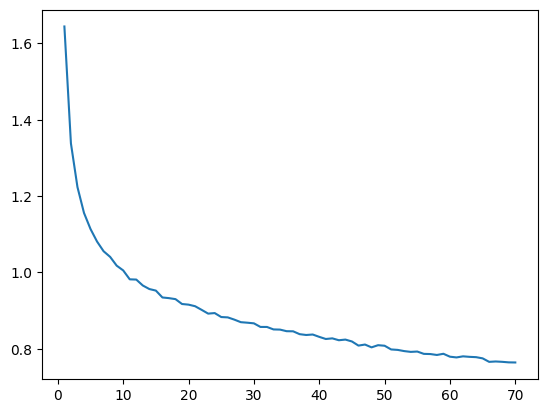

In [20]:
# 손실 및 정확도 그래프 출력
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), train_accuracies, 'o-', label='Train')
plt.plot(range(1, num_epochs+1), valid_accuracies, 'o-', label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

num_epochs = 100
batch_size = 64

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리 및 변환
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 데이터 증강 (좌우 반전)
    transforms.RandomCrop(32, padding=4),  # 데이터 증강 (랜덤 자르기)
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # CIFAR-10의 평균과 표준편차로 정규화
])

# 전체 훈련 데이터셋 로드
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 훈련 데이터셋을 80% 훈련용과 20% 검증용으로 분할
train_size = int(0.8 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size])

# 테스트 데이터셋 로드
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 데이터로더 정의
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 정의 (3채널 입력, CIFAR-10에 맞게 수정)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 합성곱 층
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3채널 입력
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # 완전 연결 층
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # CIFAR-10은 32x32 이미지, MaxPool 후 16x16
        self.fc2 = nn.Linear(128, 10)  # CIFAR-10은 10개의 클래스
        # 활성화 함수와 드롭아웃
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))   # [batch_size, 32, 32, 32]
        x = self.relu(self.conv2(x))   # [batch_size, 64, 32, 32]
        x = self.pool(x)               # [batch_size, 64, 16, 16]
        x = self.dropout(x)
        x = x.view(-1, 64 * 16 * 16)   # 평탄화
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 모델, 손실 함수, 옵티마이저 설정
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 검증 과정에서 손실과 정확도를 저장할 리스트 초기화
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# 최고 성능 모델 저장을 위한 변수
best_valid_acc = 0  # 가장 높은 검증 accuracy를 저장

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    startStr = f'Epoch {epoch+1:2d}/{num_epochs} \033[34m' + 'Train ' + '\033[0m'
    with tqdm(total=len(train_loader), desc=startStr) as pbar:
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
            pbar.update(1)
        train_loss = train_loss / train_total
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        str = f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.3f}%'
        pbar.set_postfix_str(str)

def valid_or_test(mode, model, device, dataloader):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    global best_valid_acc  # 전역 변수로 사용
    with torch.no_grad():
        if mode == 'valid':
            startStr = f'Epoch {epoch+1:2d}/{num_epochs} \033[34m' + 'Valid ' + '\033[0m'
        elif mode == 'test':
            startStr = f'Epoch {epoch+1:2d}/{num_epochs} \033[34m' + 'Test ' + '\033[0m'

        with tqdm(total=len(dataloader), desc=startStr) as pbar:
            for data, target in dataloader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)

                loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                pbar.update(1)

            loss = loss / total
            accuracy = 100 * correct / total
            if mode == 'valid':
                endStr = f'Valid Loss: {loss:.4f}, Valid Acc: {accuracy:.3f}%'
            elif mode == 'test':
                endStr = f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.3f}%'
            pbar.set_postfix_str(endStr)

    if mode == 'valid':
        valid_losses.append(loss)
        valid_accuracies.append(accuracy)
        print('-'*110)

        # 검증 accuracy가 최고 기록일 때 가중치 저장
        if accuracy > best_valid_acc:
            best_valid_acc = accuracy
            torch.save(model.state_dict(), 'best_model_acc.pth')  # 가중치 저장
            print(f'Saving model with highest validation accuracy: {best_valid_acc:.3f}%')


for epoch in range(num_epochs):
    train(model, device, train_loader, optimizer, epoch)
    valid_or_test('valid', model, device, valid_loader)

valid_or_test('test', model, device, test_loader)

# 손실 및 정확도 그래프 출력
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), train_accuracies, 'o-', label='Train')
plt.plot(range(1, num_epochs+1), valid_accuracies, 'o-', label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()
